# Python Code for Calculating the Parabolic SAR

Reference:
https://raposa.trade/blog/the-complete-guide-to-calculating-the-parabolic-sar-in-python/

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

We have a class called PSAR that allows you to adjust the initialization for the acceleration factor, its step size, and the maximum acceleration factor to calculate the **Parabolic SAR**. Despite its complexity, it really only has these three parameters to play with, which can greatly improve the performance if done correctly.

In [2]:
class PSAR:
    def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
        self.max_af = max_af
        self.init_af = init_af
        self.af = init_af
        self.af_step = af_step
        self.extreme_point = None
        self.high_price_trend = []
        self.low_price_trend = []
        self.high_price_window = deque(maxlen=2)
        self.low_price_window = deque(maxlen=2)

        # Lists to track results
        self.psar_list = []
        self.af_list = []
        self.ep_list = []
        self.high_list = []
        self.low_list = []
        self.trend_list = []
        self._num_days = 0

    def calcPSAR(self, high, low):
        if self._num_days >= 3:
            psar = self._calcPSAR()
        else:
            psar = self._initPSARVals(high, low)

        psar = self._updateCurrentVals(psar, high, low)
        self._num_days += 1

        return psar

    def _initPSARVals(self, high, low):
        if len(self.low_price_window) <= 1:
            self.trend = None
            self.extreme_point = high
            return None

        if self.high_price_window[0] < self.high_price_window[1]:
            self.trend = 1
            psar = min(self.low_price_window)
            self.extreme_point = max(self.high_price_window)
        else:
            self.trend = 0
            psar = max(self.high_price_window)
            self.extreme_point = min(self.low_price_window)

        return psar

    def _calcPSAR(self):
        prev_psar = self.psar_list[-1]
        if self.trend == 1:  # Up
            psar = prev_psar + self.af * (self.extreme_point - prev_psar)
            psar = min(psar, min(self.low_price_window))
        else:
            psar = prev_psar - self.af * (prev_psar - self.extreme_point)
            psar = max(psar, max(self.high_price_window))

        return psar

    def _updateCurrentVals(self, psar, high, low):
        if self.trend == 1:
            self.high_price_trend.append(high)
        elif self.trend == 0:
            self.low_price_trend.append(low)

        psar = self._trendReversal(psar, high, low)

        self.psar_list.append(psar)
        self.af_list.append(self.af)
        self.ep_list.append(self.extreme_point)
        self.high_list.append(high)
        self.low_list.append(low)
        self.high_price_window.append(high)
        self.low_price_window.append(low)
        self.trend_list.append(self.trend)

        return psar

    def _trendReversal(self, psar, high, low):
        # Checks for reversals
        reversal = False
        if self.trend == 1 and psar > low:
            self.trend = 0
            psar = max(self.high_price_trend)
            self.extreme_point = low
            reversal = True
        elif self.trend == 0 and psar < high:
            self.trend = 1
            psar = min(self.low_price_trend)
            self.extreme_point = high
            reversal = True

        if reversal:
            self.af = self.init_af
            self.high_price_trend.clear()
            self.low_price_trend.clear()
        else:
            if high > self.extreme_point and self.trend == 1:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = high
            elif low < self.extreme_point and self.trend == 0:
                self.af = min(self.af + self.af_step, self.max_af)
                self.extreme_point = low

        return psar

The main method is the **calcPSAR()** method which takes new highs and lows and returns tomorrow's SAR value. This will initialize our SAR if it doesn't have enough data, otherwise it calls **_calcPSAR()** which executes all of the if/else statements according to the current trend and the most recent data on hand.

Once this is complete, we have an **_updateCurrentVals()** method that will take the new high/low values and check for any reversals and make updates to our SAR if necessary.

Hopefully the code is easy enough to follow. Let's show how you can apply it to a stock.

In [3]:
ticker = '8035.T'
yfObj = yf.Ticker(ticker)
#data = yfObj.history(start='2021-09-01', end='2022-01-01')
data = yfObj.history(period='1d', interval='1m')
indic = PSAR()

data['PSAR'] = data.apply(lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)
# Add supporting data
data['EP'] = indic.ep_list
data['Trend'] = indic.trend_list
data['AF'] = indic.af_list
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,PSAR,EP,Trend,AF
Datetime,,,,,,,,,,,
2024-09-10 09:00:00+09:00,22000.0,22005.0,21710.0,21710.0,0,0.0,0.0,NaN,22005.0,NaN,0.02
2024-09-10 09:01:00+09:00,21730.0,21770.0,21615.0,21665.0,57100,0.0,0.0,NaN,21770.0,NaN,0.02
2024-09-10 09:02:00+09:00,21660.0,21715.0,21550.0,21570.0,36400,0.0,0.0,22005.000,21550.0,0.0,0.04
2024-09-10 09:03:00+09:00,21555.0,21600.0,21485.0,21600.0,63300,0.0,0.0,21986.800,21485.0,0.0,0.06
2024-09-10 09:04:00+09:00,21600.0,21605.0,21445.0,21455.0,39900,0.0,0.0,21956.692,21445.0,0.0,0.08


Once we initialize our indicator class, we can use Pandas' apply method to calculate it for each time step. Note that we only have PSAR values through December 31st in the data frame. To get the next days' prediction, we just need to call _calcPSAR() from our indicator, and then we can use it for our prediction.

In [4]:
indic._calcPSAR()

np.float64(22372.8)

Let's see how the plot looks:

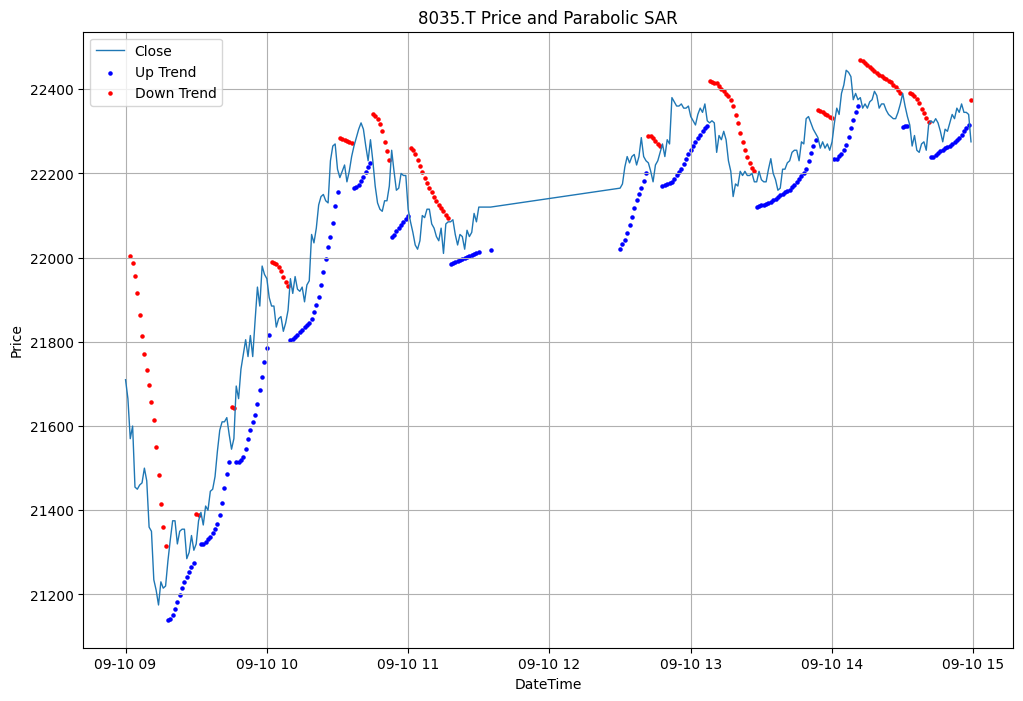

In [5]:
psar_bull = data.loc[data['Trend']==1]['PSAR']
psar_bear = data.loc[data['Trend']==0]['PSAR']

plt.figure(figsize=(12, 8))

plt.plot(data['Close'], label='Close', linewidth=1)
plt.scatter(psar_bull.index, psar_bull, color='b', s=5, label='Up Trend')
plt.scatter(psar_bear.index, psar_bear, color='r', s=5, label='Down Trend')
plt.xlabel('DateTime')
plt.ylabel('Price')

plt.title(f'{ticker} Price and Parabolic SAR')
plt.legend()
plt.grid()

plt.show()